In [18]:
import requests
import csv
import numpy as np
import nengo
from nengo.ensemble import Ensemble
from nengo.connection import Connection
from nengo.node import Node
import matplotlib.pyplot as plt

# Spike Timings from Drive-hosted CSVs

# Electrode Data URL
snippet_url = "https://drive.google.com/uc?export=download&id=1FZSPZNdLWAGy0LWYVj0oNn47FC1Y3Mso"

# Dataset Info
max_timestamp = -1.0
dt = 0.001
dti = 1/dt

# Access CSV containing snippet of electrode data
electrode_dataset = []
with requests.get(snippet_url, stream=True) as r:
    lines = (line.decode('utf-8') for line in r.iter_lines())
    for row in csv.reader(lines):
        electrode_dataset += [[float(e_val) for e_val in row]]
        row_max = max(electrode_dataset[-1])
        max_timestamp = row_max if row_max > max_timestamp else max_timestamp

# Create Time-Stamp array
t = np.arange(0, np.ceil(max_timestamp*dti)/dti,dt)
spikes = np.zeros((len(electrode_dataset), len(t)))
for i, electrode_timings in enumerate(electrode_dataset):
    spikes[i,:], _ = np.histogram(np.array(electrode_dataset[i]), t.shape[0], [0, max_timestamp])
spikes = spikes * dti

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:02.                                                 


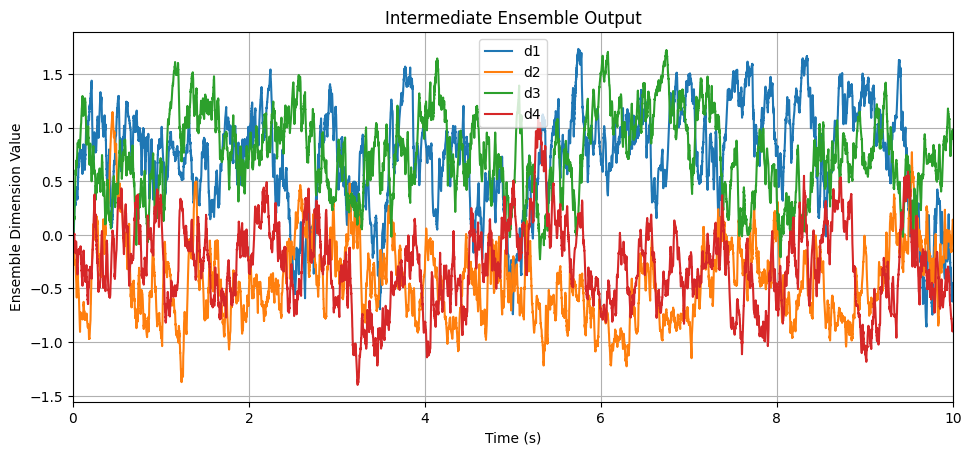

In [39]:
# Nengo Network Using Recorded Spikes as Input
np.random.seed(0)
with nengo.Network() as model:
    node_in = Node(lambda t: spikes[:,int(t / dt) - 1])
    ens_inter = Ensemble(n_neurons=500, dimensions=4)
    con_in_inter = Connection(node_in, ens_inter, transform=np.random.normal(size=(4,49)))
    p_ens = nengo.Probe(ens_inter,synapse=0.05)

with nengo.Simulator(model, dt=dt, seed=0) as sim:
    sim.run(10)

fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_ens]);
pl.set_title("Intermediate Ensemble Output")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["d1", "d2", "d3", "d4"])
pl.grid()